In [1]:
import numpy as np
import pprint
import seaborn as sns
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt

# Class Objects for State and Agent

In [2]:
BOARD_ROWS = 5
BOARD_COLS = 8
START = (1,0)
DETERMINISTIC = False

R_obs = -1
R_lit = 1

In [3]:
a = (0,0)
b = (1,2)
MAX_DIST = distance.euclidean(a,b)
print(MAX_DIST)

2.23606797749979


In [28]:
class State:
    def __init__(self, module, state=START):
        self.MODS = ['MOD_WALK','MOD_AVOID','MOD_PICKUP']
        self.module = module
        self.board = self.generateBoard()               
        self.state = state
        self.isEnd = False
        self.determine = DETERMINISTIC  
        
    def generateBoard(self):
        board = np.zeros([BOARD_ROWS, BOARD_COLS])
        
        # SIDEWALK
        if self.module == self.MODS[0]:
            # distination
            board[1:BOARD_ROWS-1,BOARD_COLS-1] = 1
            # not sidewalk
            board[0,:] = -1
            board[BOARD_ROWS-1,:] = -1
        
        n = BOARD_ROWS*BOARD_COLS
        obj_pos = [x for x in random.sample(range(n), int(0.4*n))]
        m = int(len(obj_pos)/2)
                
        # OBSTACLES
        if self.module == self.MODS[1]:
            obs_pos = obj_pos[0:m]
            for pos in obs_pos:
                # no obstacles or litter on first or last columns
                if (pos%BOARD_COLS != 0) and (pos%BOARD_COLS != BOARD_COLS-1):
                    board[pos//BOARD_COLS][pos%BOARD_COLS] = R_obs
                
        # LITTER
        if self.module == self.MODS[2]:
            lit_pos = obj_pos[m+1:]
            for pos in lit_pos:
                # no obstacles or litter on first or last columns
                if (pos%BOARD_COLS != 0) and (pos%BOARD_COLS != BOARD_COLS-1):
                    board[pos//BOARD_COLS][pos%BOARD_COLS] = R_lit
                    
        return board
        
    def giveReward(self):     
        if self.module == self.MODS[0]:
            return self.board[self.state]
        
        # if on object, penalize by R_obs
        if self.board[self.state] == R_obs:
            return R_obs
        
        # if on litter, reward by R_lit
        if self.board[self.state] == R_lit:
            return R_lit
        
        # else find dist of closest object
        closest_obj = MAX_DIST
        x = self.state[0]
        y = self.state[1]        
        for i in range(x-1,x+1 +1):
            for j in range(y,y+2 +1):
                # check if window is within boards
                if i < 0 or i >= BOARD_ROWS or j < 0 or j >= BOARD_COLS:
                    continue
                
                # check if position has object
                if self.board[i, j] != 0:
                    a = (i,j)
                    dist = distance.euclidean(a,b)
                    if dist < closest_obj:
                        closest_obj = dist
                
        # 2.25 is approx the furthest distance an object can be in this window
        if self.module == self.MODS[1]:
            reward = min(1, closest_obj / MAX_DIST)
        elif self.module == self.MODS[2]:
            reward = max(0, closest_obj / MAX_DIST)
        
        return reward

    def isEndFunc(self):
        if self.state[1] == BOARD_COLS - 1 and self.state[0] > 0 and self.state[0] < BOARD_ROWS-1:
            self.isEnd = True
        if self.state == R_obs:
            self.isEnd = True

    def _chooseActionProb(self, action):
        if action == "up":
            return np.random.choice(["up", "left", "right"], p=[0.8, 0.1, 0.1])
        if action == "down":
            return np.random.choice(["down", "left", "right"], p=[0.8, 0.1, 0.1])
        if action == "left":
            return np.random.choice(["left", "up", "down"], p=[0.8, 0.1, 0.1])
        if action == "right":
            return np.random.choice(["right", "up", "down"], p=[0.8, 0.1, 0.1])

    def nxtPosition(self, action):
        if self.determine:
            if action == "up":
                nxtState = (self.state[0], self.state[1] + 1)
            elif action == "down":
                nxtState = (self.state[0], self.state[1] - 1)
            elif action == "left":
                nxtState = (self.state[0] - 1, self.state[1])
            else:
                nxtState = (self.state[0] + 1, self.state[1])
            self.determine = False
        else:
            # non-deterministic
            action = self._chooseActionProb(action)
            self.determine = True
            nxtState = self.nxtPosition(action)

        # if next state is legal
        if (nxtState[0] >= 0) and (nxtState[0] <= BOARD_ROWS-1):
            if (nxtState[1] >= 0) and (nxtState[1] <= BOARD_COLS-1):
                return nxtState
        return self.state

    def showBoard(self):
        self.board[self.state] = 2
        for i in range(0, BOARD_ROWS):
            print('----'*BOARD_COLS + '-')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 2:
                    token = 'A'
                if self.board[i, j] == 1:
                    token = '1'
                if self.board[i, j] == -1 and self.module == self.MODS[0]:
                    token = '-'
                if self.board[i, j] == R_obs and self.module == self.MODS[1]:
                    token = '*'
                if self.board[i, j] == R_lit and self.module == self.MODS[2]:
                    token = '$'
                if self.board[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('----'*BOARD_COLS + '-')

In [29]:
class Agent:
    def __init__(self, module, lr=0.5, epsilon=0.9):
        self.module = module
        self.states = []  # record position and action taken at the position
        self.actions = ["up", "down", "left", "right"]
        self.State = State(module=self.module)
        self.isEnd = self.State.isEnd
        self.lr = lr
        self.exp_rate = 1 - epsilon
        self.epsilon = epsilon
        
        # initial Q values
        self.Q_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0  # Q value is a dict of dict
    
    def chooseAction(self):
        # choose action with most expected value
        mx_nxt_reward = 0
        action = ""

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            current_position = self.State.state
            action = max(self.Q_values[current_position])                
#             print("current pos: {}, greedy aciton: {}".format(self.State.state, action))
        return action

    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        # update State
        return State(module=self.module, state=position)

    def reset(self):
        self.states = []
        self.State = State(module=self.module)
        self.isEnd = self.State.isEnd

    def play(self, rounds=10):
        i = 0
        while i < rounds:
            # to the end of game back propagate reward
            if self.State.isEnd:
                # back propagate
                reward = self.State.giveReward()
                for a in self.actions:
                    self.Q_values[self.State.state][a] = reward
                for s in reversed(self.states):
                    current_q_value = self.Q_values[s[0]][s[1]]
                    reward = current_q_value + self.lr * (self.epsilon * reward - current_q_value)
                    self.Q_values[s[0]][s[1]] = round(reward, 3)
                self.reset()
                i += 1
            else:
                action = self.chooseAction()
                # append trace
                self.states.append([(self.State.state), action])
                # by taking the action, it reaches the next state
                self.State = self.takeAction(action)
                # mark is end
                self.State.isEndFunc()
                self.isEnd = self.State.isEnd
                
        print(f'Game End Reward {round(reward,4)}')

# Sidewalk Module

In [141]:
s = State(module='MOD_WALK')
print(s.state)
print(s.showBoard())

(1, 0)
---------------------------------
| - | - | - | - | - | - | - | - | 
---------------------------------
| A | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 
---------------------------------
| - | - | - | - | - | - | - | - | 
---------------------------------
None


In [177]:
random.seed(8)
sidewalk = Agent(module='MOD_WALK', lr=0.5)
print(sidewalk.module)

MOD_WALK


In [178]:
sidewalk.play(1000)
final_sidewalk = sidewalk.Q_values
# pprint.pprint(sidewalk.Q_values)

Game End Reward 0.2643


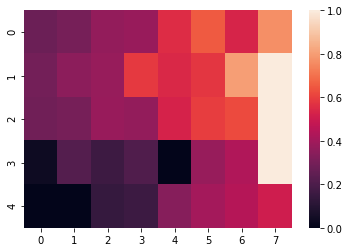

In [145]:
hm = np.zeros([BOARD_ROWS, BOARD_COLS])
for i in range(BOARD_ROWS):
    for j in range(BOARD_COLS):
        hm[i,j] = final_sidewalk[(i,j)]['right']
        
ax = sns.heatmap(hm)

# Obstacles Module

In [146]:
random.seed(8)
s = State(module='MOD_AVOID')
print(s.state)
print(s.showBoard())

(1, 0)
---------------------------------
| 0 | 0 | * | 0 | 0 | * | 0 | 0 | 
---------------------------------
| A | 0 | 0 | 0 | * | 0 | * | 0 | 
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
---------------------------------
| 0 | 0 | 0 | 0 | * | 0 | 0 | 0 | 
---------------------------------
None


In [189]:
R_obs = R = -1
rounds = 100
m = 'MOD_AVOID'

random.seed(8)
obstacle = Agent(module=m, lr=0.5)
print(obstacle.module)

MOD_AVOID


In [190]:
obstacle.play(rounds)
final_obstacle = obstacle.Q_values
# pprint.pprint(obstacle.Q_values)

Game End Reward 0.2642


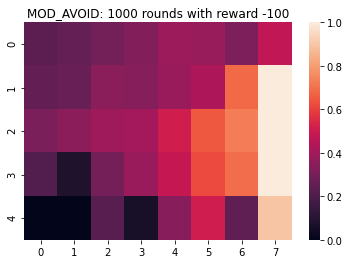

In [150]:
hm = np.zeros([BOARD_ROWS, BOARD_COLS])
for i in range(BOARD_ROWS):
    for j in range(BOARD_COLS):
        hm[i,j] = final_obstacle[(i,j)]['left']


ax = sns.heatmap(hm).set_title(f'{m}: {rounds} rounds with reward {R}')

# Litter Module

In [62]:
random.seed(8)
s = State(module='MOD_PICKUP')
print(s.state)
print(s.showBoard())

(1, 0)
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | $ | 0 | 
---------------------------------
| s | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
---------------------------------
| 0 | 0 | 0 | 0 | $ | 0 | 0 | 0 | 
---------------------------------
| 0 | $ | 0 | 0 | 0 | 0 | 0 | 0 | 
---------------------------------
| 0 | 0 | 0 | $ | 0 | 0 | 0 | 0 | 
---------------------------------
None


In [94]:
R_lit = R = 100
rounds = 1000
m = 'MOD_PICKUP'

random.seed(8)
litter = Agent(module=m)
print(litter.module)

MOD_PICKUP


In [ ]:
litter.play(rounds)
final_litter = litter.Q_values

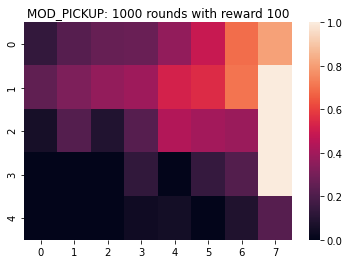

In [96]:
hm = np.zeros([BOARD_ROWS, BOARD_COLS])
for i in range(BOARD_ROWS):
    for j in range(BOARD_COLS):
        hm[i,j] = final_litter[(i,j)]['right']
        
ax = sns.heatmap(hm).set_title(f'{m}: {rounds} rounds with reward {R}')

# Combined Modules

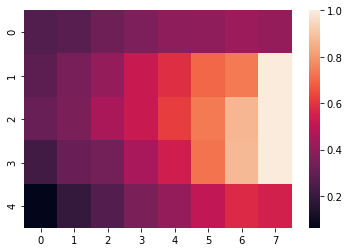

In [25]:
Q_final = np.zeros([BOARD_ROWS, BOARD_COLS])
for i in range(BOARD_ROWS):
    for j in range(BOARD_COLS):
        u = (final_sidewalk[(i,j)]['up'] + final_obstacle[(i,j)]['up'] + final_litter[(i,j)]['up'])/3
        d = (final_sidewalk[(i,j)]['down'] + final_obstacle[(i,j)]['down'] + final_litter[(i,j)]['down'])/3
        l = (final_sidewalk[(i,j)]['left'] + final_obstacle[(i,j)]['left'] + final_litter[(i,j)]['left'])/3
        r = (final_sidewalk[(i,j)]['right'] + final_obstacle[(i,j)]['right'] + final_litter[(i,j)]['right'])/3
        
        Q_final[i,j] = u
        
ax = sns.heatmap(hm)

# Experiments - learning rate and reward

In [30]:
BOARD_ROWS = 5
BOARD_COLS = 8
START = (1,0)
DETERMINISTIC = False

alpha = [0.2, 0.5, 0.7]
reward = [1, 10, 100]
rounds = [100, 1000, 2500]

## Sidewalk Module Optimization

In [31]:
random.seed(8)

module = 'MOD_WALK'

s = State(module=module)
print(s.state)
print(s.showBoard())

(1, 0)
---------------------------------
| - | - | - | - | - | - | - | - | 
---------------------------------
| A | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 
---------------------------------
| - | - | - | - | - | - | - | - | 
---------------------------------
None


In [32]:
random.seed(8)

Q_sidewalk = []

for a in alpha:  
    for n in rounds:
        agent = Agent(module=module, lr=a)
        agent.play(n)
        Q_sidewalk.append(agent.Q_values)
        print(f'\t\t with alpha {a} and rounds {n}')

Game End Reward 0.0263
		 with alpha 0.2 and rounds 100
Game End Reward 0.2842
		 with alpha 0.2 and rounds 1000
Game End Reward 0.316
		 with alpha 0.2 and rounds 2500
Game End Reward 0.2586
		 with alpha 0.5 and rounds 100
Game End Reward 0.3441
		 with alpha 0.5 and rounds 1000
Game End Reward 0.3158
		 with alpha 0.5 and rounds 2500
Game End Reward 0.3373
		 with alpha 0.7 and rounds 100
Game End Reward 0.233
		 with alpha 0.7 and rounds 1000
Game End Reward 0.3051
		 with alpha 0.7 and rounds 2500


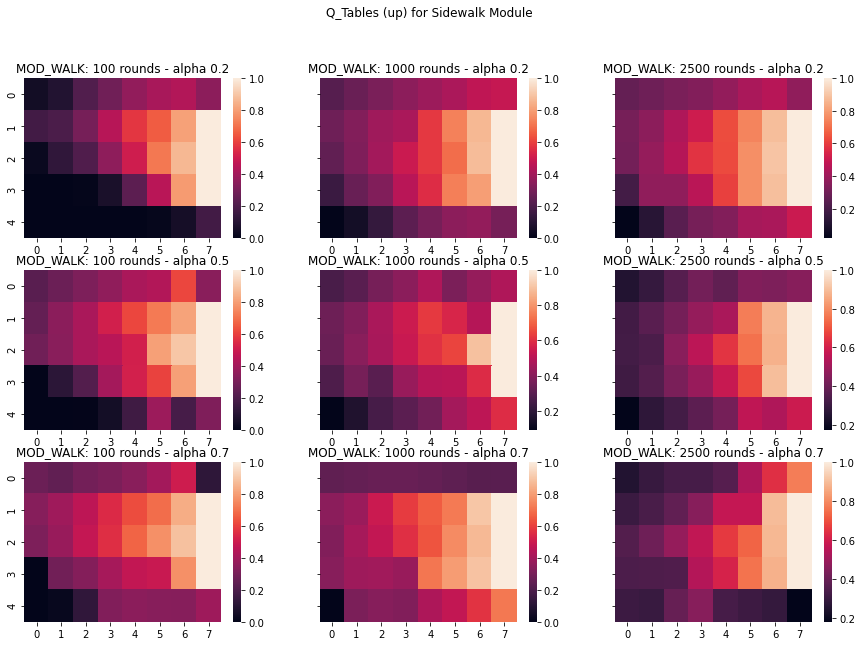

In [46]:
action = 'up'

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharey=True)
fig.suptitle(f'Q_Tables ({action}) for Sidewalk Module')

A = [0.2,0.2,0.2, 0.5,0.5,0.5, 0.7,0.7,0.7]
R = [100,1000,2500, 100,1000,2500, 100,1000,2500]

for s in range(9):
    hm = np.zeros([BOARD_ROWS, BOARD_COLS])
    for i in range(BOARD_ROWS):
        for j in range(BOARD_COLS):
            hm[i,j] = Q_sidewalk[s][(i,j)][action]
    sns.heatmap(hm, ax=axes.flat[s]).set_title(f'MOD_WALK: {R[s]} rounds - alpha {A[s]}')

## Obstacle Optimization

In [34]:
random.seed(8)

module = 'MOD_AVOID'

s = State(module=module)
print(s.state)
print(s.showBoard())

(1, 0)
---------------------------------
| 0 | 0 | * | 0 | 0 | * | 0 | 0 | 
---------------------------------
| A | 0 | 0 | 0 | * | 0 | * | 0 | 
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
---------------------------------
| 0 | 0 | 0 | 0 | * | 0 | 0 | 0 | 
---------------------------------
None


In [35]:
random.seed(8)

Q_obstacles = []

for a in alpha:  
    for r in reward:
        R_obs = -r
        agent = Agent(module=module, lr=a)
        agent.play(n)
        Q_obstacles.append(agent.Q_values)
        print(f'\t\t with alpha {a} and reward {-r}')

Game End Reward 0.2609
		 with alpha 0.2 and reward -1
Game End Reward 0.2611
		 with alpha 0.2 and reward -10
Game End Reward 0.3028
		 with alpha 0.2 and reward -100
Game End Reward 0.297
		 with alpha 0.5 and reward -1
Game End Reward 0.2647
		 with alpha 0.5 and reward -10
Game End Reward 0.3496
		 with alpha 0.5 and reward -100
Game End Reward 0.3416
		 with alpha 0.7 and reward -1
Game End Reward 0.3123
		 with alpha 0.7 and reward -10
Game End Reward 0.3199
		 with alpha 0.7 and reward -100


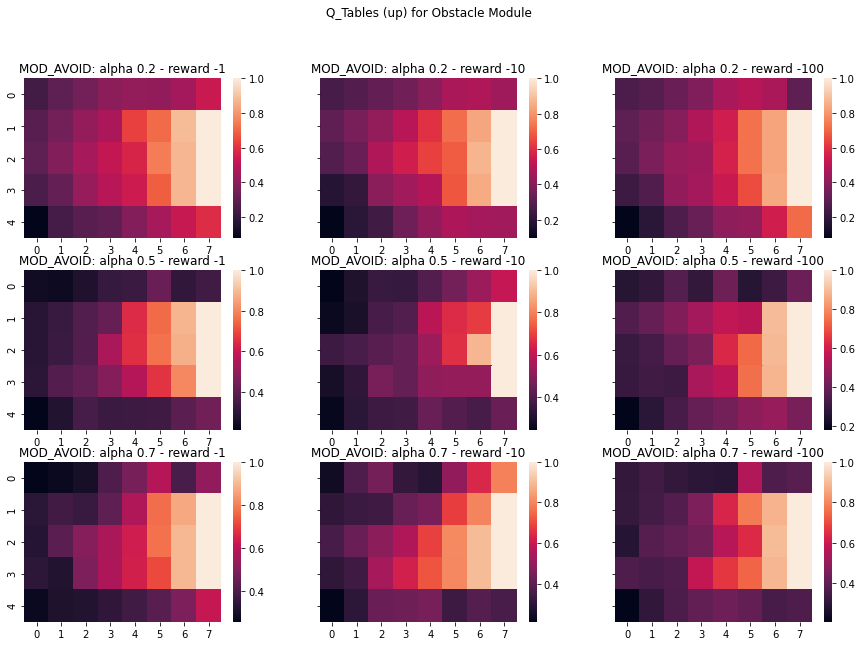

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharey=True)
fig.suptitle(f'Q_Tables ({action}) for Obstacle Module')

A = [0.2,0.2,0.2, 0.5,0.5,0.5, 0.7,0.7,0.7]
Re = [1,10,100, 1,10,100, 1,10,100]

for s in range(9):
    hm = np.zeros([BOARD_ROWS, BOARD_COLS])
    for i in range(BOARD_ROWS):
        for j in range(BOARD_COLS):
            hm[i,j] = Q_obstacles[s][(i,j)][action]
    sns.heatmap(hm, ax=axes.flat[s]).set_title(f'MOD_AVOID: alpha {A[s]} - reward {-Re[s]}')

## Litter Optimization

In [37]:
random.seed(8)

module = 'MOD_PICKUP'

s = State(module=module)
print(s.state)
print(s.showBoard())

(1, 0)
---------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | $ | 0 | 
---------------------------------
| A | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
---------------------------------
| 0 | 0 | 0 | 0 | $ | 0 | 0 | 0 | 
---------------------------------
| 0 | $ | 0 | 0 | 0 | 0 | 0 | 0 | 
---------------------------------
| 0 | 0 | 0 | $ | 0 | 0 | 0 | 0 | 
---------------------------------
None


In [38]:
random.seed(8)

Q_litter = []

for a in alpha:  
    for r in reward:
        R_obs = r
        agent = Agent(module=module, lr=a)
        agent.play(n)
        Q_litter.append(agent.Q_values)
        print(f'\t\t with alpha {a} and reward {r}')

Game End Reward 0.3058
		 with alpha 0.2 and reward 1
Game End Reward 0.294
		 with alpha 0.2 and reward 10
Game End Reward 0.2923
		 with alpha 0.2 and reward 100
Game End Reward 0.28
		 with alpha 0.5 and reward 1
Game End Reward 0.3394
		 with alpha 0.5 and reward 10
Game End Reward 0.2873
		 with alpha 0.5 and reward 100
Game End Reward 0.359
		 with alpha 0.7 and reward 1
Game End Reward 0.2666
		 with alpha 0.7 and reward 10
Game End Reward 0.3999
		 with alpha 0.7 and reward 100


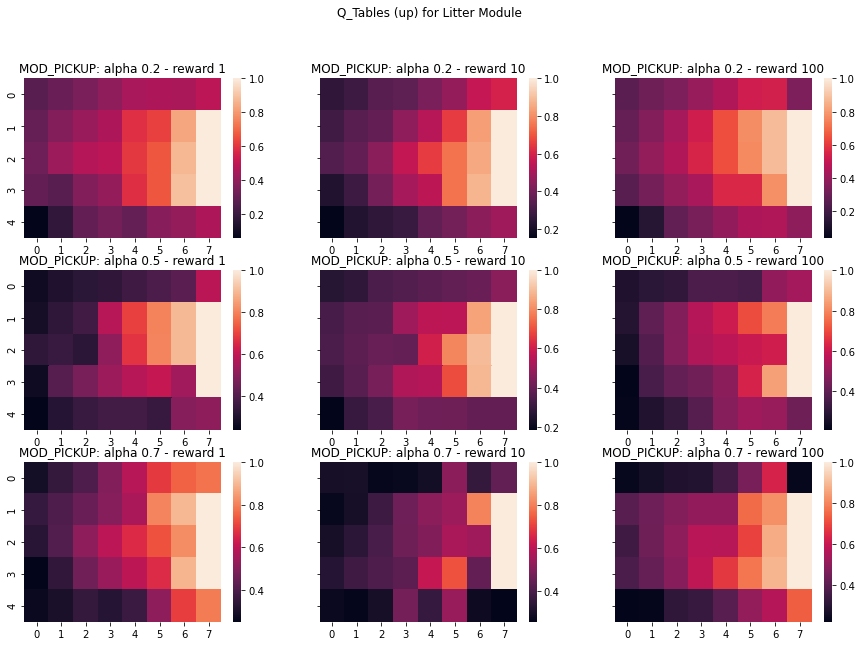

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharey=True)
fig.suptitle(f'Q_Tables ({action}) for Litter Module')

A = [0.2,0.2,0.2, 0.5,0.5,0.5, 0.7,0.7,0.7]
Re = [1,10,100, 1,10,100, 1,10,100]

for s in range(9):
    hm = np.zeros([BOARD_ROWS, BOARD_COLS])
    for i in range(BOARD_ROWS):
        for j in range(BOARD_COLS):
            hm[i,j] = Q_litter[s][(i,j)][action]
    sns.heatmap(hm, ax=axes.flat[s]).set_title(f'MOD_PICKUP: alpha {A[s]} - reward {Re[s]}')

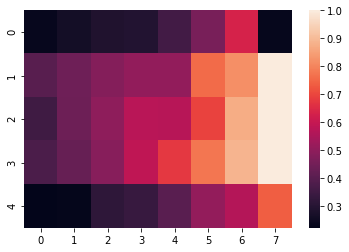

In [51]:
action = 'up'
Q_final = np.zeros([BOARD_ROWS, BOARD_COLS])
for i in range(BOARD_ROWS):
    for j in range(BOARD_COLS):
        a = (Q_sidewalk[4][(i,j)][action] + Q_obstacles[5][(i,j)][action] + Q_litter[8][(i,j)][action])/3        
        Q_final[i,j] = a
        
ax = sns.heatmap(hm)